# TP SSII Classification d'images

Fait par Théophile Yvars et Robin Viollet

# Imports

In [15]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn import preprocessing
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.cluster import KMeans
import numpy as np
from sklearn import svm

# Variables

In [2]:
# Nombre de cluster souhaité
k_count = 50

# Données

In [3]:
# Récupération des images
lfw = fetch_lfw_people(min_faces_per_person=100,resize=1)

# Récupération des classes
classesNames = []
for name in lfw.target_names:
    classesNames.append(name)
print(classesNames)

# On veut 75% d'images d'entrainements
X = lfw.images
y = lfw.target
Xtrain, Xtest, yTrain, yTest = train_test_split(X, y, test_size=0.25, random_state=33)

['Colin Powell', 'Donald Rumsfeld', 'George W Bush', 'Gerhard Schroeder', 'Tony Blair']


# Classification par Régression Linéaire

## Apprentissage

###                             DESCRIPTEURS SIFT

In [4]:
# ---------------------------------------------
# On veut récuperer les SIFTs des images
# ---------------------------------------------

# variable sift
sift = cv2.SIFT_create()

# img recupere les images d'entrainements
img = Xtrain

# Recupere les informations des images
kp = list()
des = list()

# Recupere les descripteurs SIFTs des images (myDes) + le nombres de descripteurs sift par image (myDesLen)
myDes = []
myDesLen = []

# Pour le nombre d'image
for i in range(len(img)):
    # On normalise l'image
    imgTmp = cv2.normalize(img[i], None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    # Recupere les informations de l'image
    kpTmp, desTmp = sift.detectAndCompute(imgTmp,None)
    # Stock les informations
    kp.append(kpTmp)
    des.append(desTmp)
    # Pour chaque descripteur sift de l'image
    for data in desTmp:
        # Stock le descripteur sift
        myDes.append(data)
    # Stock le nombre de descripteur sift de l'image analysé
    myDesLen.append(len(desTmp))
    #print(len(desTmp))

### PARTITIONNEMENT PAR KMEANS

In [5]:
# ---------------------------------------------
# On veut construire les barycentre
# ---------------------------------------------

kmeans1 = KMeans(n_clusters=k_count, init='k-means++')
# On entraine le model avec les descripteurs sifts
kmeans1.fit(myDes)
print(kmeans1)

KMeans(n_clusters=50)


### CALCUL DES BOWS

In [6]:
# ---------------------------------------------
# On veut faire une prédiction avec les données d'entrainements
# ---------------------------------------------

# On recupère les données d'entrainements
classes = yTrain

# Variables
bofs = np.empty(shape=(len(classes),k_count)) # tableau des numéros de cluster pour les 
# descripteurs sifts des images
i = 0 # Index de bofs
j = 0 # Index de lecture du nombre de sift pour l'image analysée
k = 1 # Pour affichage du numéros de prediction

# Pour le nombre de descripteurs sifts d'une image / Pour chaque image
for ds in myDesLen:
    # Tableau temporaire qui recupère les numéros de cluster
    tmpBof = np.array([0]*k_count)
    # Recupere les sifts de l'image
    sifts = myDes[j:j+ds]
    j += ds
    #print("Predict ",k," ...")
    k=k+1
    # Pour chaque sift de l'image
    for sift in sifts:
        # Predit le cluster
        clusterID = kmeans1.predict([sift])
        # Stock le cluster
        tmpBof[clusterID[0]] += 1
    # Stock les clusters de l'image
    bofs[i] = tmpBof
    i+= 1

### REGRESSION LINEAIRE

In [7]:
# ---------------------------------------------
# Résolution par regression linéaire
# ---------------------------------------------

# Fabrication du model
logic_reg_2 = LogisticRegression()
scaler_2 = preprocessing.StandardScaler().fit(bofs)
xTrain2 = scaler_2.transform(bofs)

# Données d'entrainement
yTrain2 = []
for clNumber in yTrain:
    yTrain2 += [clNumber]

# Entrainement du model
logic_reg_2.fit(xTrain2, yTrain2)

LogisticRegression()

### PREDICTION

In [8]:
# Prediction
ypred2 = logic_reg_2.predict(xTrain2)
# Affichage du résutat
print("train F1 score = ", f1_score(yTrain2, ypred2, average = 'micro'))
print("train accuracy score = ", accuracy_score(yTrain2, ypred2))

train F1 score =  0.7122807017543858
train accuracy score =  0.712280701754386


### MATRICE DE CONFUSION

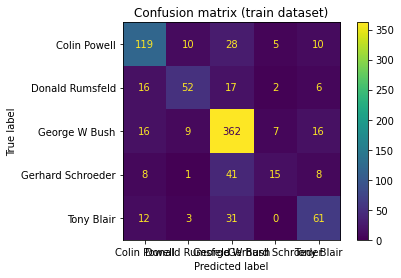

In [9]:
# ---------------------------------------------
# Matrice de confusion
# ---------------------------------------------

# Noms des peronnes sur les images
classes = classesNames

# Construction de la matrice
cm2 = confusion_matrix(yTrain2, ypred2, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=classes)
disp.plot()
disp.ax_.set_title('Confusion matrix (train dataset)')

# Affichage
plt.show()

## Prédiction données de test

### DESCRIPTEUR SIFT

In [10]:
# ---------------------------------------------
# On veut récuperer les SIFTs des images
# ---------------------------------------------

# variable sift
sift = cv2.SIFT_create()

# img recupere les images d'entrainements
imgTest = Xtest

# Recupere les informations des images
kp = list()
des = list()

# Recupere les descripteurs SIFTs des images (myDes) + le nombres de descripteurs sift par image (myDesLen)
myDes = []
myDesLen = []

# Pour le nombre d'image
for i in range(len(imgTest)):
    # On normalise l'image
    imgTmp = cv2.normalize(img[i], None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    # Recupere les informations de l'image
    kpTmp, desTmp = sift.detectAndCompute(imgTmp,None)
    # Stock les informations
    kp.append(kpTmp)
    des.append(desTmp)
    # Pour chaque descripteur sift de l'image
    for data in desTmp:
        # Stock le descripteur sift
        myDes.append(data)
    # Stock le nombre de descripteur sift de l'image analysé
    myDesLen.append(len(desTmp))

classes = yTest

# Variables
testBofs = np.empty(shape=(len(classes),k_count)) # tableau des numéros de cluster pour les 
# descripteurs sifts des images
i = 0 # Index de bofs
j = 0 # Index de lecture du nombre de sift pour l'image analysée
k = 1 # Pour affichage du numéros de prediction

# Pour le nombre de descripteurs sifts d'une image / Pour chaque image
for ds in myDesLen:
    # Tableau temporaire qui recupere les numéros de cluster
    tmpBof = np.array([0]*k_count)
    # Recupere les sifts de l'image
    sifts = myDes[j:j+ds]
    j += ds
    #print("Predict ",k," ...")
    k=k+1
    # Pour chaque sift de l'image
    for sift in sifts:
        # Predit le cluster
        clusterID = kmeans1.predict([sift])
        # Stock le cluster
        tmpBof[clusterID[0]] += 1
    # Stock les clusters de l'image
    testBofs[i] = tmpBof
    i+= 1

xTest2 = scaler_2.transform(testBofs)

# Données d'entrainement
yTest2 = []
for clNumber in yTest:
    yTest2 += [clNumber]

### PREDICTION

In [11]:
# Prediction
ypred = logic_reg_2.predict(xTest2)
# Affichage du résutat
print("train F1 score = ", f1_score(yTest2, ypred, average = 'micro'))
print("train accuracy score = ", accuracy_score(yTest2, ypred))

train F1 score =  0.3157894736842105
train accuracy score =  0.3157894736842105


### MATRICE DE CONFUSION

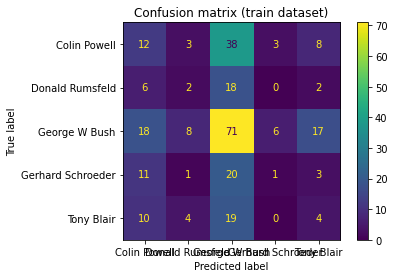

In [12]:
# ---------------------------------------------
# Matrice de confusion
# ---------------------------------------------

# Noms des peronnes sur les images
classes = classesNames

# Construction de la matrice
cm2 = confusion_matrix(yTest2, ypred, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=classes)
disp.plot()
disp.ax_.set_title('Confusion matrix (train dataset)')

# Affichage
plt.show()

# Classification par SVM

## Evaluation de la classification

In [13]:
# variable sift
sift = cv2.SIFT_create()

# img recupere les images d'entrainements
img = Xtest

# Recupere les informations des images
kp = list()
des = list()

# Recupere les descripteurs SIFTs des images (myDes) + le nombres de descripteurs sift par image (myDesLen)
myDes = []
myDesLen = []

# Pour le nombre d'image
for i in range(len(img)):
    # On normalise l'image
    imgTmp = cv2.normalize(img[i], None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    # Recupere les informations de l'image
    kpTmp, desTmp = sift.detectAndCompute(imgTmp,None)
    # Stock les informations
    kp.append(kpTmp)
    des.append(desTmp)
    # Pour chaque descripteur sift de l'image
    for data in desTmp:
        # Stock le descripteur sift
        myDes.append(data)
    # Stock le nombre de descripteur sift de l'image analysé
    myDesLen.append(len(desTmp))
    #print(len(desTmp))


classes = yTest

bofs_test = np.empty(shape=(len(classes),k_count))

# descripteurs sifts des images
i = 0 # Index de bofs
j = 0 # Index de lecture du nombre de sift pour l'image analysée
k = 1 # Pour affichage du numéros de prediction

# Pour le nombre de descripteurs sifts d'une image / Pour chaque image
for ds in myDesLen:
    # Tableau temporaire qui recupere les numéros de cluster
    tmpBof = np.array([0]*k_count)
    # Recupere les sifts de l'image
    sifts = myDes[j:j+ds]
    j += ds
    #print("Predict ",k," ...")
    k=k+1
    # Pour chaque sift de l'image
    for sift in sifts:
        # Predit le cluster
        clusterID = kmeans1.predict([sift])
        # Stock le cluster
        tmpBof[clusterID[0]] += 1
    # Stock les clusters de l'image
    bofs_test[i] = tmpBof
    i+= 1

## Kernel : linear && Decision_function_shape=ovr

In [16]:
#X = [[0, 0], [1, 1]]
#y = [0,1]

#print(Xtest)

X = bofs_test
y = yTest


# classif = svm.SVC(kernel='linear')
classif = svm.SVC(kernel='linear', decision_function_shape='ovr')
classif.fit(X, y)

#print(Xtest.shape)

ypred2linearovr = classif.predict(X)

#print("prediction class for [2,2]", classif.predict([[2., 2.]])
#print("support vectors: ", classif.support_vectors_)

In [17]:
linearovr = f1_score(y, ypred2linearovr, average = 'micro')
print("train F1 score = ", linearovr)
print("train accuracy score = ", accuracy_score(y, ypred2linearovr))

train F1 score =  0.9859649122807017
train accuracy score =  0.9859649122807017


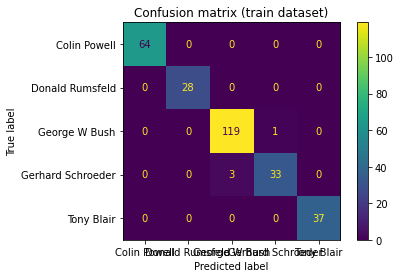

In [18]:
# Noms des peronnes sur les images
classes = classesNames

# Construction de la matrice
cm2 = confusion_matrix(y, ypred2linearovr, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=classes)
disp.plot()
disp.ax_.set_title('Confusion matrix (train dataset)')

# Affichage
plt.show()

## Kernel : rbf && Decision_function_shape=ovr

In [19]:
X = bofs_test
y = yTest


# classif = svm.SVC(kernel='linear')
classif = svm.SVC(kernel='rbf', decision_function_shape='ovr')
classif.fit(X, y)

#print(Xtest.shape)

ypred2rbfovr = classif.predict(X)

#print("prediction class for [2,2]", classif.predict([[2., 2.]])
#print("support vectors: ", classif.support_vectors_)

In [20]:
rbfovr = f1_score(y, ypred2rbfovr, average = 'micro')
print("train F1 score = ", rbfovr)
print("train accuracy score = ", accuracy_score(y, ypred2rbfovr))

train F1 score =  0.8947368421052632
train accuracy score =  0.8947368421052632


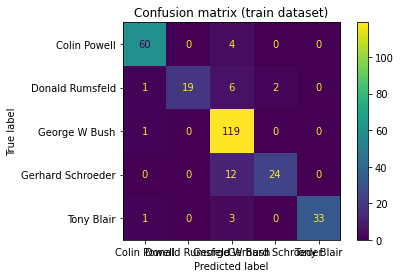

In [21]:
# Noms des peronnes sur les images
classes = classesNames

# Construction de la matrice
cm2 = confusion_matrix(y, ypred2rbfovr, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=classes)
disp.plot()
disp.ax_.set_title('Confusion matrix (train dataset)')

# Affichage
plt.show()

## Kernel : poly && Decision_function_shape=ovr

In [22]:
X = bofs_test
y = yTest

# classif = svm.SVC(kernel='linear')
classif = svm.SVC(kernel='poly', decision_function_shape='ovr')
classif.fit(X, y)

#print(Xtest.shape)

ypred2polyovr = classif.predict(X)

#print("prediction class for [2,2]", classif.predict([[2., 2.]])
#print("support vectors: ", classif.support_vectors_)

In [23]:
polyovr = f1_score(y, ypred2polyovr, average = 'micro')
print("train F1 score = ", polyovr)
print("train accuracy score = ", accuracy_score(y, ypred2polyovr))

train F1 score =  0.9789473684210527
train accuracy score =  0.9789473684210527


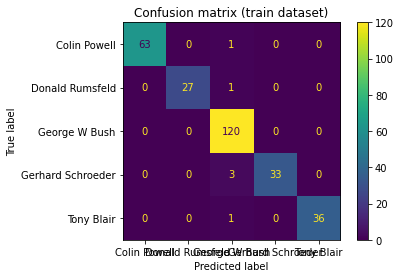

In [24]:
# Noms des personnes sur les images
classes = classesNames

# Construction de la matrice
cm2 = confusion_matrix(y, ypred2polyovr, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=classes)
disp.plot()
disp.ax_.set_title('Confusion matrix (train dataset)')

# Affichage
plt.show()

## Kernel : linear && Decision_function_shape=ovo

In [25]:
X = bofs_test
y = yTest


# classif = svm.SVC(kernel='linear')
classif = svm.SVC(kernel='linear', decision_function_shape='ovo')
classif.fit(X, y)

#print(Xtest.shape)

ypred2linearovo = classif.predict(X)

#print("prediction class for [2,2]", classif.predict([[2., 2.]])
#print("support vectors: ", classif.support_vectors_)

In [26]:
linearovo = f1_score(y, ypred2linearovo, average = 'micro')
print("train F1 score = ", linearovo)
print("train accuracy score = ", accuracy_score(y, ypred2linearovo))

train F1 score =  0.9859649122807017
train accuracy score =  0.9859649122807017


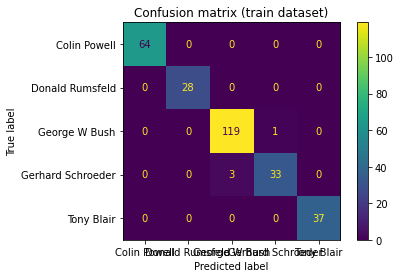

In [27]:
# Noms des peronnes sur les images
classes = classesNames

# Construction de la matrice
cm2 = confusion_matrix(y, ypred2linearovo, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=classes)
disp.plot()
disp.ax_.set_title('Confusion matrix (train dataset)')

# Affichage
plt.show()

## Kernel : rbf && Decision_function_shape=ovo

In [28]:
X = bofs_test
y = yTest


# classif = svm.SVC(kernel='linear')
classif = svm.SVC(kernel='rbf', decision_function_shape='ovo')
classif.fit(X, y)

#print(Xtest.shape)

ypred2rbfovo = classif.predict(X)

#print("prediction class for [2,2]", classif.predict([[2., 2.]])
#print("support vectors: ", classif.support_vectors_)

In [29]:
rbfovo = f1_score(y, ypred2rbfovo, average = 'micro')
print("train F1 score = ", f1_score(y, ypred2rbfovo, average = 'micro'))
print("train accuracy score = ", accuracy_score(y, ypred2rbfovo))

train F1 score =  0.8947368421052632
train accuracy score =  0.8947368421052632


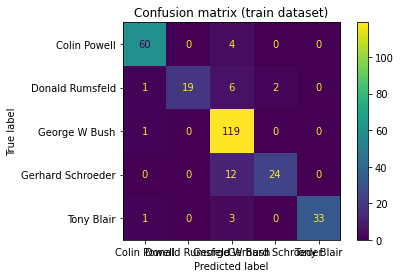

In [30]:
# Noms des peronnes sur les images
classes = classesNames

# Construction de la matrice
cm2 = confusion_matrix(y, ypred2rbfovo, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=classes)
disp.plot()
disp.ax_.set_title('Confusion matrix (train dataset)')

# Affichage
plt.show()

## Kernel : poly && Decision_function_shape=ovo

In [31]:
X = bofs_test
y = yTest


# classif = svm.SVC(kernel='linear')
classif = svm.SVC(kernel='poly', decision_function_shape='ovo')
classif.fit(X, y)

#print(Xtest.shape)

ypred2polyovo = classif.predict(X)

#print("prediction class for [2,2]", classif.predict([[2., 2.]])
#print("support vectors: ", classif.support_vectors_)

In [32]:
polyovo = f1_score(y, ypred2polyovo, average = 'micro')
print("train F1 score = ", polyovo)
print("train accuracy score = ", accuracy_score(y, ypred2polyovo))

train F1 score =  0.9789473684210527
train accuracy score =  0.9789473684210527


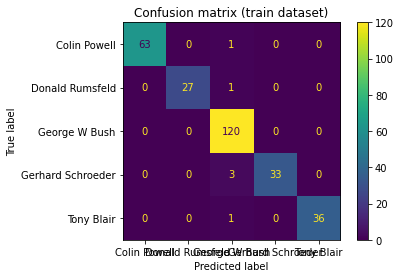

In [33]:
# Noms des peronnes sur les images
classes = classesNames

# Construction de la matrice
cm2 = confusion_matrix(y, ypred2polyovo, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=classes)
disp.plot()
disp.ax_.set_title('Confusion matrix (train dataset)')

# Affichage
plt.show()

Pour C = 1.0 (valeur par défaut)

| Kcount | entrainement | regression lineaire | linear ovr | rbf ovr | poly ovr | linear ovo | rbf ovo | poly ovo |
|--------|--------------|---------------------|------------|---------|----------|------------|---------|----------|
| 10     | 53%          | 34%                 | 57%        | 61%     | 75%      | 57%        | 61%     | 75%      |
| 20     | 63%          | 32%                 | 67%        | 77%     | 95%      | 67%        | 77%     | 95%      |
| 50     | 70%          | 30%                 | 97%        | 91%     | 97%      | 97%        | 91%     | 97%      |
| 100    | 86%          | 31%                 | 100%       | 95%     | 96%      | 100%       | 95%     | 96%      |

Pour C = 2.0

| Kcount | entrainement | regression lineaire | linear ovr | rbf ovr | poly ovr | linear ovo | rbf ovo | poly ovo |
|--------|--------------|---------------------|------------|---------|----------|------------|---------|----------|
| 50     | 71%          | 32%                 | 98%        | 98%     | 98%      | 98%        | 98%     | 98%      |

Pour C = 5.0

| Kcount | entrainement | regression lineaire | linear ovr | rbf ovr | poly ovr | linear ovo | rbf ovo | poly ovo |
|--------|--------------|---------------------|------------|---------|----------|------------|---------|----------|
| 50     | 71%          | 32%                 | 100%       | 100%    | 100%     | 100%       | 100%    | 100%     |

# Paramètres SVM

Avec une valeur de k faible, le noyau poly semble mieux s'en sortir que les autres. Poly permet d'efficacement séparer des clusters peu nombreux et potentiellement intriqués. Pour un k mieux choisi, le noyau linéaire est le plus efficace avec une précision se rapprochant de 100%.

Quant à la valeur de C nous avons testé les valeurs 1.0 (valeurs par défaut), 2.0 et 5.0. 5.0 donne une précision de 100%. D'autres valeurs pourraient être testées mais les résultats obtenus sont déjà très satisfaisants.

# Conclusion

En conclusion, on a pu voir lors de ce TP que les problèmes de classification d'images n'ont rien de trivial et qeu le choix des paramètres passés aux différents algorithmes influencent grandement les résultats obtenus.

Les résultats obtenus ne sont pas forcément satisfaisant. Les différentes valeurs de k testées (10, 40, 50, 100, 200) ont donné des résultats plus ou moins exacts. 40 semble être la valeur avec la meilleure balance des scores F1 entre les données d'apprentissage et de test. Les valeurs supérieures à 100 semblent mener à un sur-apprentissage, avec la précision des prédictions sur les données d'entrainement qui se rapproche de 1 alors que la précision sur les données de test s'effondre, atteignant 20% ou 30%. On peut rapeller qu'avec des données réparties en 5 classes, une précision de 20% revient à faire une prédiction aléatoire.

Plusieurs remarques peuvent être faites à partir des résultats obtenus :

1. George W. Bush est sur-représenté dans les données founries, autant pour les données d'entrainement que les données de tests. Cela peut amener à des résultats biaisés, notamment lors d'une prédiction sur des images correspondant aux autres classes.

2. La régression linéaire est la méthode la moins précise avec seulement 34% de précision.

3. La méthode SVM utilisée avec le bons arguments peut donner de très bons résultats.